# Integrating patient-derived AML single-cell RNA-seq data

Andrew Ashford, Pathways + Omics Group - OHSU, 6/6/2024

This Jupyter Notebook will primarily be used to explore the integration of the single-cell RNA-seq data between several patients in a single-cell AML patient cohort. Ultimately, the integrated data will be used to train and test a mutation prediction workflow.


In [2]:
# Import modules
import scanpy as sc
import pandas as pd
import harmonypy as hm
import sys
from scipy.io import mmread


#### Read in the vanGalen data h5ad file

In [35]:
# Specify directory
vangalen_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/'


In [38]:
# Specify h5ad filename
seurat_file = 'vanGalen_anndata.h5ad'


In [39]:
# Read into an AnnData object
vangalen_scrna_adata = sc.read_h5ad(vangalen_dir + seurat_file)


In [40]:
print(vangalen_scrna_adata)


AnnData object with n_obs × n_vars = 44823 × 27899
    obs: 'orig.ident', 'NumberOfReads', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRefined', 'CellType', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'


In [41]:
print(vangalen_scrna_adata.obs['MutTranscripts'])


BM1_AGGCGGGCGTGN         NA
BM1_ATAACATTTCAC         NA
BM1_ACGCTCTGGCCN         NA
BM1_TTGCACAGAGGA         NA
BM1_TGTATTGCTTTG         NA
                         ..
OCI.AML3_TGAAAACACTTN    NA
OCI.AML3_TGCTCGTCGCGT    NA
OCI.AML3_TGCTGTCGCGCG    NA
OCI.AML3_TGTCCGCGCCCA    NA
OCI.AML3_TGTGTCAAGCGA    NA
Name: MutTranscripts, Length: 44823, dtype: object


In [42]:
print(vangalen_scrna_adata.obs['CellType'])
print(vangalen_scrna_adata.var['features'])


BM1_AGGCGGGCGTGN              HSC
BM1_ATAACATTTCAC              HSC
BM1_ACGCTCTGGCCN             Prog
BM1_TTGCACAGAGGA             Prog
BM1_TGTATTGCTTTG         earlyEry
                           ...   
OCI.AML3_TGAAAACACTTN    cDC-like
OCI.AML3_TGCTCGTCGCGT    cDC-like
OCI.AML3_TGCTGTCGCGCG    cDC-like
OCI.AML3_TGTCCGCGCCCA    cDC-like
OCI.AML3_TGTGTCAAGCGA    cDC-like
Name: CellType, Length: 44823, dtype: object
A1BG            A1BG
A1BG-AS1    A1BG-AS1
A1CF            A1CF
A2M              A2M
A2M-AS1      A2M-AS1
              ...   
ZYG11A        ZYG11A
ZYG11B        ZYG11B
ZYX              ZYX
ZZEF1          ZZEF1
ZZZ3            ZZZ3
Name: features, Length: 27899, dtype: object


#### Normalize and scale the data

In [9]:
# Preprocess scRNA-seq data
sc.pp.normalize_total(vangalen_scrna_adata, target_sum=1e4)
sc.pp.log1p(vangalen_scrna_adata)
sc.pp.highly_variable_genes(vangalen_scrna_adata, n_top_genes=4000)  # Adjust as needed


In [10]:
# Filter to just the highly-variable gene features
vangalen_scrna_adata = vangalen_scrna_adata[:, vangalen_scrna_adata.var.highly_variable]


In [11]:
# Scale the data (center to zero mean and scale to unit variance)
#sc.pp.scale(vangalen_scrna_adata, zero_center=True, max_value=10)

# Can also just scale to Z-scores like this (center to zero mean and scale to unit variance)
sc.pp.scale(vangalen_scrna_adata, zero_center=True)


/home/groups/precepts/ashforda/anaconda3/envs/scOPE_working_environment/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
print(vangalen_scrna_adata)


AnnData object with n_obs × n_vars = 44823 × 4000
    obs: 'orig.ident', 'NumberOfReads', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRefined', 'CellType', 'nCount_RNA', 'nFeature_RNA'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'


#### Make plots to look at the data

In [13]:
# UMAP visualization of integrated data as a check
sc.pp.neighbors(vangalen_scrna_adata, use_rep='X')
sc.tl.umap(vangalen_scrna_adata)


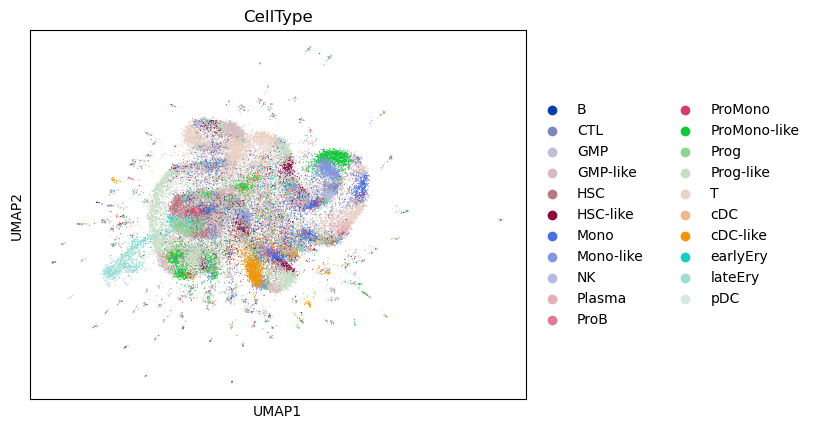

In [14]:
# Look at plot colored by CellType
sc.pl.umap(vangalen_scrna_adata, color=['CellType'])


In [15]:
# Convert orig.ident to string type for the plot
vangalen_scrna_adata.obs['orig.ident'] = vangalen_scrna_adata.obs['orig.ident'].astype(str)


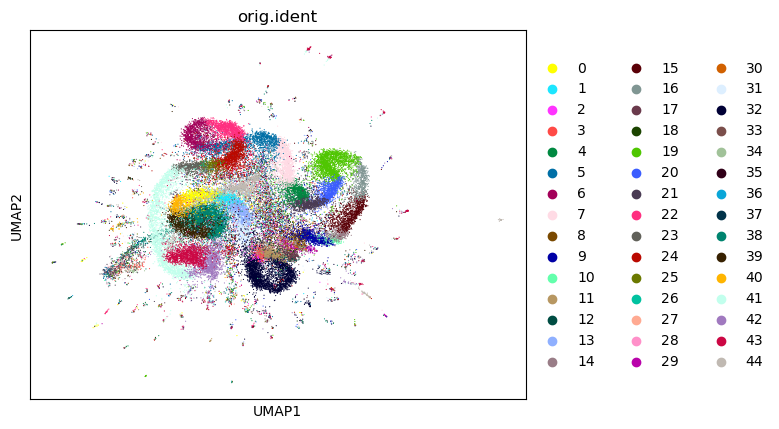

In [16]:
# Look at plot colored by patient
sc.pl.umap(vangalen_scrna_adata, color=['orig.ident'])


#### Integrate the scRNA-seq data using Harmony

In [17]:
# Specify number of PCs to use
n_pcs = 50


In [18]:
# Run PCA with specified numbers of PCs
sc.tl.pca(vangalen_scrna_adata, n_comps=n_pcs)


In [19]:
# Sanity check
print(vangalen_scrna_adata)


AnnData object with n_obs × n_vars = 44823 × 4000
    obs: 'orig.ident', 'NumberOfReads', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRefined', 'CellType', 'nCount_RNA', 'nFeature_RNA'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'CellType_colors', 'orig.ident_colors', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


In [20]:
# Run Harmony
harmony_out = hm.run_harmony(vangalen_scrna_adata.obsm['X_pca'], vangalen_scrna_adata.obs, 'orig.ident', max_iter_harmony=100)


2024-06-06 17:47:45,993 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-06 17:48:16,252 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-06 17:48:16,623 - harmonypy - INFO - Iteration 1 of 100
2024-06-06 17:48:35,972 - harmonypy - INFO - Iteration 2 of 100
2024-06-06 17:48:55,114 - harmonypy - INFO - Iteration 3 of 100
2024-06-06 17:49:13,998 - harmonypy - INFO - Iteration 4 of 100
2024-06-06 17:49:32,754 - harmonypy - INFO - Iteration 5 of 100
2024-06-06 17:49:51,627 - harmonypy - INFO - Iteration 6 of 100
2024-06-06 17:50:01,837 - harmonypy - INFO - Iteration 7 of 100
2024-06-06 17:50:11,509 - harmonypy - INFO - Iteration 8 of 100
2024-06-06 17:50:20,337 - harmonypy - INFO - Iteration 9 of 100
2024-06-06 17:50:29,343 - harmonypy - INFO - Iteration 10 of 100
2024-06-06 17:50:38,236 - harmonypy - INFO - Converged after 10 iterations


In [21]:
# Update the PCA embedding with the Harmony output
vangalen_scrna_adata.obsm['X_pca'] = harmony_out.Z_corr.T


In [22]:
print(vangalen_scrna_adata)
print(vangalen_scrna_adata.obsm['X_pca'])
print(vangalen_scrna_adata.obsm['X_pca'].shape)


AnnData object with n_obs × n_vars = 44823 × 4000
    obs: 'orig.ident', 'NumberOfReads', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRefined', 'CellType', 'nCount_RNA', 'nFeature_RNA'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'CellType_colors', 'orig.ident_colors', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
[[-1.2326815  -5.254614    0.57205325 ...  0.3393202   0.02053872
   0.6784157 ]
 [ 5.7287197   4.3464174   5.1053624  ...  0.6297648  -0.6858993
   0.7158895 ]
 [-1.6132643  -3.6373317   1.9950693  ... -0.18760233  0.22770336
   0.77518547]
 ...
 [-6.3961854   6.6226854  -1.7273314  ... -0.39886805  1.153271
  -0.5733015 ]
 [-3.3243566  10.696495   -0.08696488 ... -0.55000925  0.87631756
   0.62698686]
 [-2.761641   -4.031494    0.15187931 ...  0.39254305  0.20369212
   1.0068783 ]]
(44823, 50)


In [23]:
print(vangalen_scrna_adata.obsm['X_pca'].max())
print(vangalen_scrna_adata.obsm['X_pca'].min())


308.88834
-193.55742


#### Plot the integrated data

In [24]:
# UMAP visualization
sc.pp.neighbors(vangalen_scrna_adata, use_rep='X_pca')
sc.tl.umap(vangalen_scrna_adata)


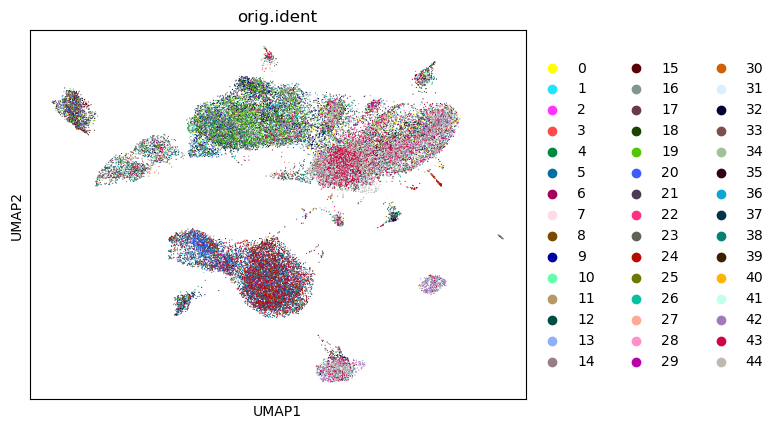

In [25]:
# See plot
sc.pl.umap(vangalen_scrna_adata, color=['orig.ident'])


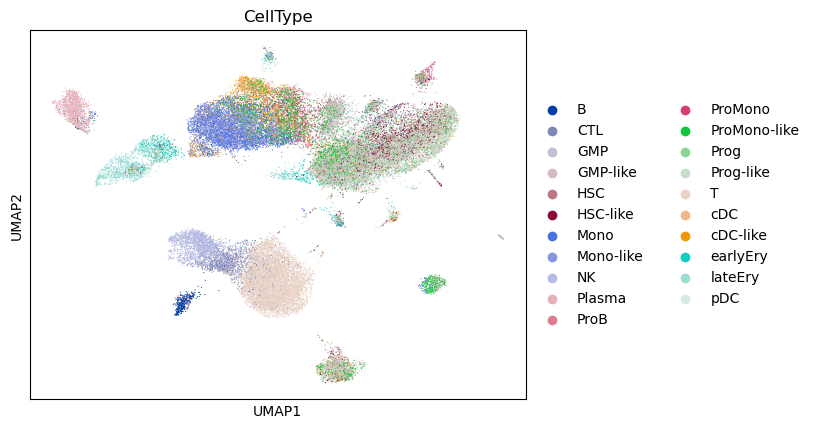

In [26]:
# Show plot
sc.pl.umap(vangalen_scrna_adata, color=['CellType'])


/tmp/ipykernel_42894/2772126593.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(vangalen_scrna_adata, resolution=0.50)  # Adjust resolution parameter as needed


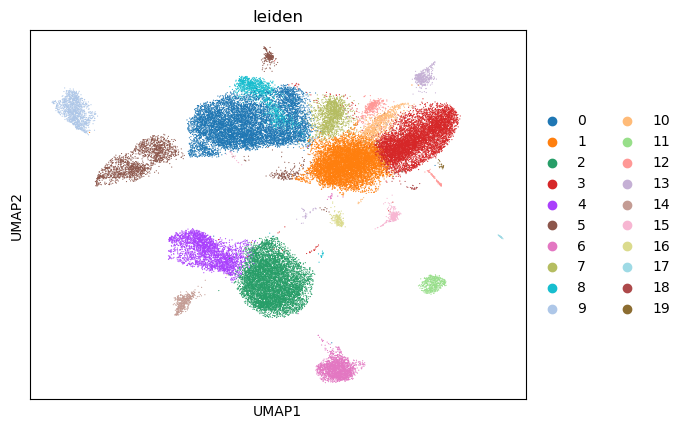

In [27]:
sc.tl.leiden(vangalen_scrna_adata, resolution=0.50)  # Adjust resolution parameter as needed
sc.pl.umap(vangalen_scrna_adata, color=['leiden'])  # UMAP visualization colored by cluster


In [28]:
'''
# See which genes are the major sources of variation between clusters
sc.tl.rank_genes_groups(vangalen_scrna_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(vangalen_scrna_adata, n_genes=20, sharey=False)
'''


"\n# See which genes are the major sources of variation between clusters\nsc.tl.rank_genes_groups(vangalen_scrna_adata, 'leiden', method='wilcoxon')\nsc.pl.rank_genes_groups(vangalen_scrna_adata, n_genes=20, sharey=False)\n"

#### Save AnnData object to an h5ad file

In [30]:
# Convert 'orig.ident' to string type
vangalen_scrna_adata.obs['orig.ident'] = vangalen_scrna_adata.obs['orig.ident'].astype(str)


In [31]:
# Check column names in var
print(vangalen_scrna_adata)
print(vangalen_scrna_adata.var.columns)


AnnData object with n_obs × n_vars = 44823 × 4000
    obs: 'orig.ident', 'NumberOfReads', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRefined', 'CellType', 'nCount_RNA', 'nFeature_RNA', 'leiden'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'CellType_colors', 'orig.ident_colors', 'pca', 'leiden', 'leiden_colors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
Index(['features', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm', 'mean', 'std'],
      dtype='object')


In [32]:
# Rename '_index' column in raw.var to help with error I was getting while trying to save to a h5ad file
if '_index' in vangalen_scrna_adata.raw.var.columns:
    vangalen_scrna_adata.raw.var.rename(columns={'_index': 'index_col'}, inplace=True)

# Rename '_index' column in var if exists
if '_index' in vangalen_scrna_adata.var.columns:
    vangalen_scrna_adata.var.rename(columns={'_index': 'index_col'}, inplace=True)

# Rename '_index' column in obs if exists
if '_index' in vangalen_scrna_adata.obs.columns:
    vangalen_scrna_adata.obs.rename(columns={'_index': 'index_col'}, inplace=True)


In [33]:
print(vangalen_scrna_adata.raw)
#print(vangalen_scrna_adata.raw.var['_index'])


Raw AnnData with n_obs × n_vars = 44823 × 27899
    var: 'index_col'


In [34]:
# Save the integrated data
save_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/'
save_filename = 'integrated_vanGalen_scRNA_all_data.h5ad'

vangalen_scrna_adata.write(save_dir + save_filename)
